## Transient Data Analysis

In [179]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import emcee 
import time
import corner

In [180]:
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\Data\transient.npy")

In [181]:
Time = data.T[0]
vals = data.T[1]
errs = data.T[2]

In [185]:
# Define the likelihood function (PDF)
def pdf(x):
    """
    Probability density function for the transient data.
    
    Parameters
    ----------
    Time : array-like
        The time values.
    A : float
        The amplitude of the transient.
    b : float
        The constant offset of the transient.
    alpha : float
        The decay constant.
    x0 : float
        The time at which decay starts.
    
    Returns
    -------
    array-like
        The PDF evaluated at each time point.
    """
    output = np.where(Time > x[3], x[1] + x[0] * np.exp(-x[2] * (Time - x[3])), x[1])
    return output

def func(Time,A,b,alpha,t0):
    output = np.where(Time > t0, b + A * np.exp(-alpha * (Time -t0)),b)
    return output

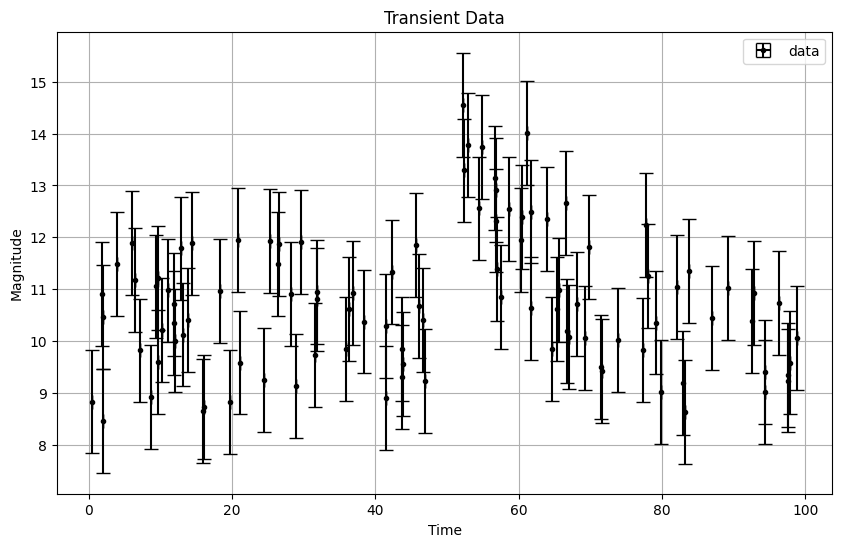

In [336]:
plt.figure(figsize=(10, 6))
plt.errorbar(Time, vals, xerr=0, yerr=errs,capsize=5, fmt=".", label="data", color='black')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Transient Data')
plt.legend()

Guess parameters estimates:
1. b = $ \frac{1}{30} \sum_{i=1}^{30} y_i$
2. A = $\max\{y\}$ - b
3. $\alpha = t$ | $ y(\alpha) = \frac{\max\{y\}}{e}$
4. $t_0 = t$ | $y(t) = \max\{y\} $ 

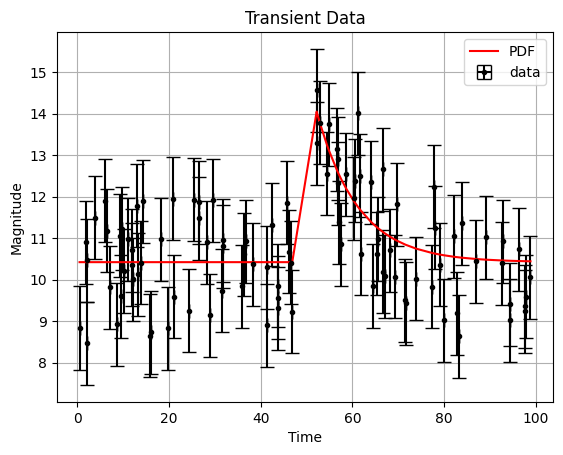

In [187]:
plt.errorbar(Time, vals, xerr=0, yerr=errs,capsize=5, fmt=".", label="data", color='black')
plt.plot(Time,func(Time,*np.array([max(vals)-vals[:20].mean(),vals[:20].mean(),1/9,np.argmax(vals)])), color='red', label="PDF")
plt.grid()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Transient Data')
plt.legend()

In [ ]:
from scipy import stats
import numpy as np

def prior(x):
    """
    Log prior for parameters [A, b, alpha, x0].
    Uniform priors:
    - A, b: between 0 and 50
    - alpha: between 0 and 100
    - x0: between exp(-5) and exp(5), uniform in log space
    """
    A, b, alpha, x0 = x

    if not (0 <= A <= 50 and 0 <= b <= 50 and 0 <= alpha <= 100 and np.exp(-5) <= x0 <= np.exp(5)):
        return -np.inf  # outside the prior bounds

    log_prior_A     = np.log(1.0 / 50)   # uniform(0, 50)
    log_prior_b     = np.log(1.0 / 50)
    log_prior_alpha = np.log(1.0 / 100)
    log_prior_x0    = np.log(1.0 / (np.exp(5) - np.exp(-5)))

    return log_prior_A + log_prior_b + log_prior_alpha + log_prior_x0

def log_likelihood(x):
    """
    Gaussian log-likelihood for the transient signal model.
    If data follow the model +/- stocastic errors, the likelihood will follow the chi-squared distribution, with N-V degrees of freedom.
    Parameters
    ----------
    
    x : array-like
        The parameters [A, b, alpha, x0].
        
    Returns
    -------
    float
        The log-likelihood value.
    """
    y_model = pdf(x)  # or func(Time, *x)

    if np.any(np.isnan(y_model)) or np.any(~np.isfinite(y_model)):
        return -np.inf

    return -0.5 * np.sum(((vals - y_model) / errs)**2)


def posterior(x):
    """
    Log posterior function combining prior and likelihood.
    """
    
    log_prior_value = prior(x)
    if not np.isfinite(log_prior_value):
        return -np.inf

    log_like = log_likelihood(x)
    if not np.isfinite(log_like):
        return -np.inf

    return log_like + log_prior_value



In [309]:
ndim     = 4  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nsteps   = int(1e5)  # number of MCMC steps to take **for each walker**

In [310]:
guess_parameters = np.array([max(vals)/2,vals[:20].mean(),0.2,50]) + np.random.randn(nwalkers, ndim) * 1e-6

In [311]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior)
elapsed=time.time()
print("Starting MCMC...")
sampler.run_mcmc(guess_parameters, nsteps)
print("MCMC finished in %s seconds" % (time.time() - elapsed))

Starting MCMC...
MCMC finished in 148.70201969146729 seconds


In [312]:
tau = sampler.get_autocorr_time()

In [313]:
print(tau)

[91.77861724 69.25866481 77.77712679 89.75618903]


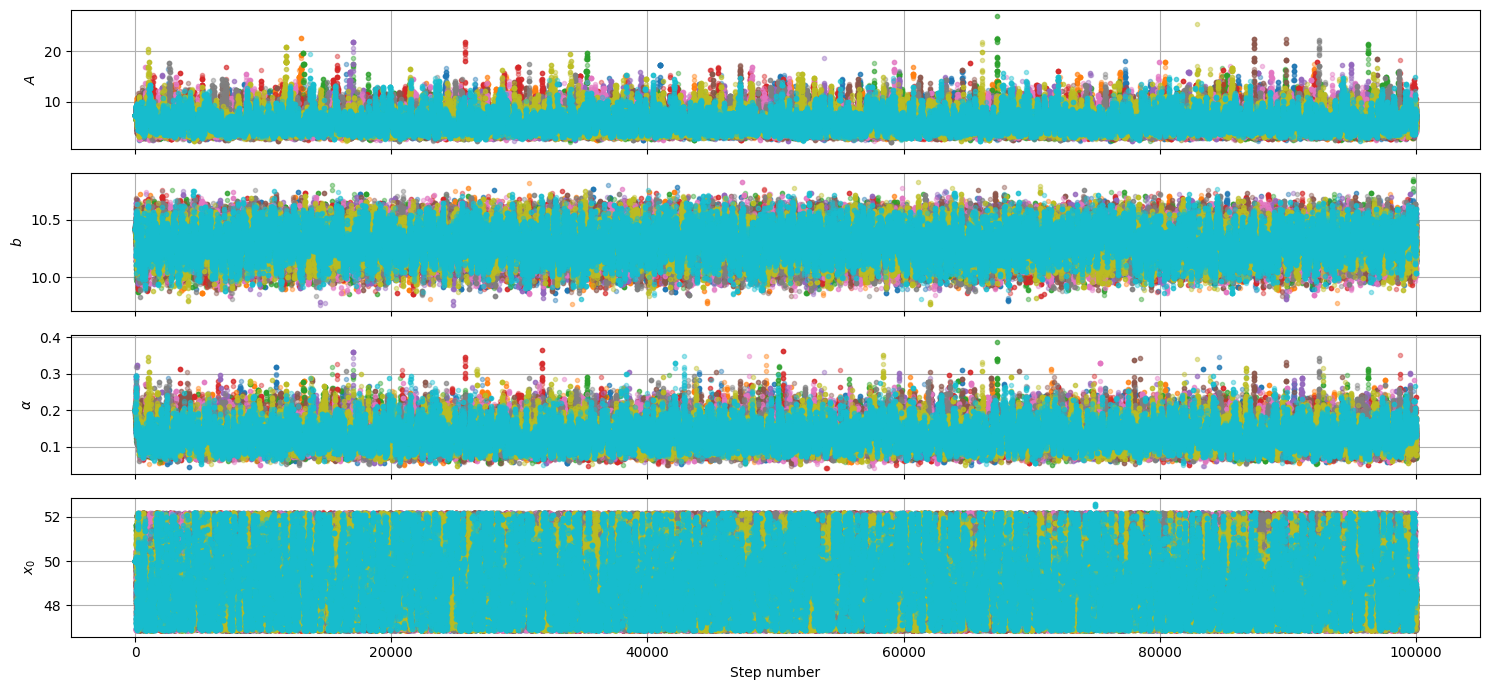

In [314]:
labels = [r"$A$", r"$b$", r"$\alpha$", r"$x_{0}$"]
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.get_chain()[:,:,i], '.',alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)
axes[-1].set_xlabel("Step number")
plt.tight_layout()


Burn first 300 points

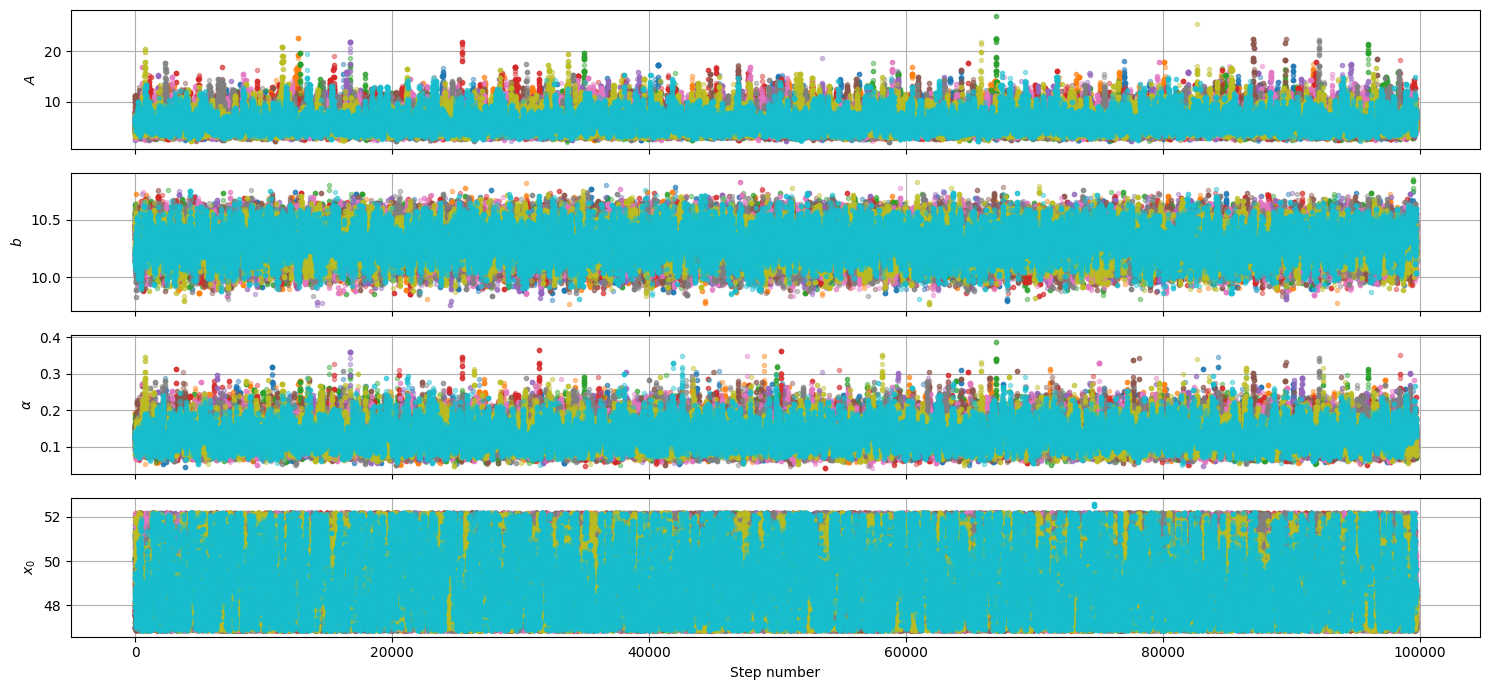

In [315]:
labels = [r"$A$", r"$b$", r"$\alpha$", r"$x_{0}$"]
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.get_chain()[300:, :, i], '.',alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)
axes[-1].set_xlabel("Step number")
plt.tight_layout()


In [331]:
samples = sampler.get_chain(flat=False, discard=300, thin=int(max(tau)))
flat_samples = sampler.get_chain(flat=True, discard=300, thin=int(max(tau)))

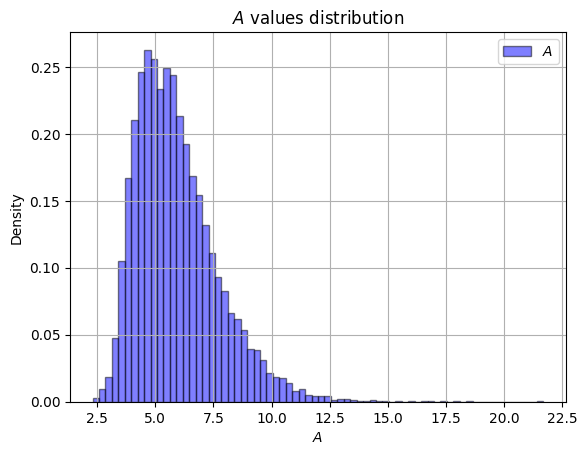

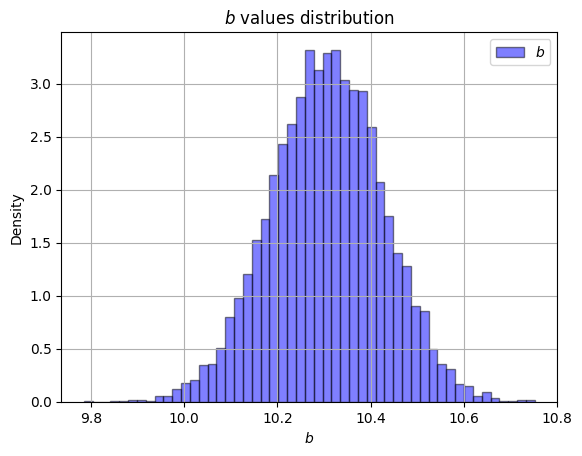

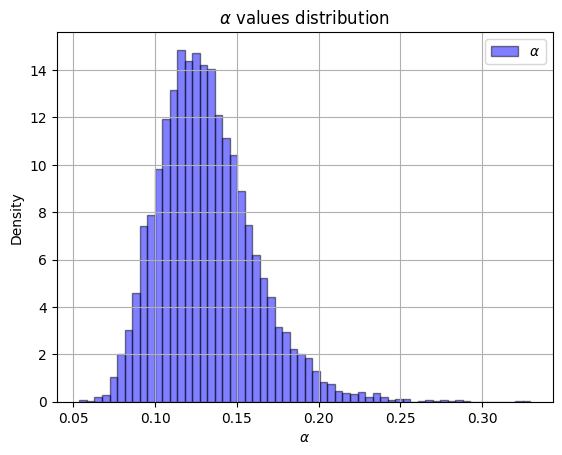

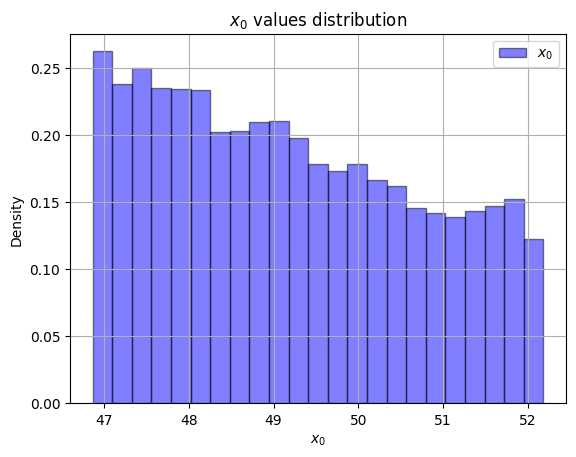

In [332]:
for i in range(4):
    plt.hist(flat_samples.T[i], bins='scott', density=True, histtype='barstacked', label=labels[i], alpha=0.5, color='blue', edgecolor='black')
    plt.ylabel('Density')
    plt.xlabel(labels[i])
    plt.legend()
    plt.grid()
    plt.title(labels[i]+" values distribution")
    plt.show()

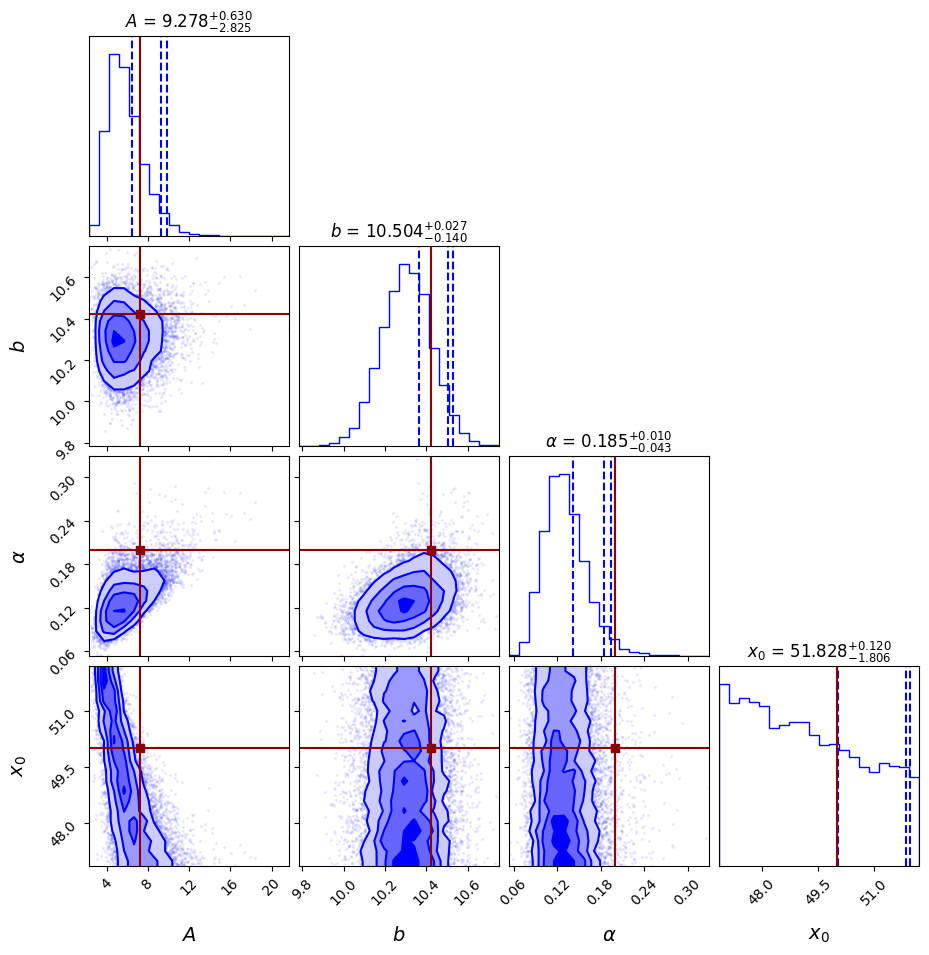

In [333]:
# Define true values (make sure vals is defined appropriately)
true_values = np.array([
    max(vals) / 2,
    np.mean(vals[:20]),
    0.2,
    50
])

# Generate corner plot
fig = corner.corner(
    flat_samples,
    labels=labels,  # customize these labels as needed
    truths=true_values,
    quantiles=[0.68, 0.95, 0.97],
    show_titles=True,
    title_fmt=".3f",              # Number format in titles
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    truth_color="darkred",
    color="blue",
    fill_contours=True
)


In [334]:
x_vals = np.random.uniform(0, samples.shape[0], 100).astype(int)
walker = np.random.randint(0, samples.shape[1], 1).astype(int)
p0 = samples[x_vals,walker,0]
p1 = samples[x_vals,walker,1]
p2 = samples[x_vals,walker,2]
p3 = samples[x_vals,walker,3]

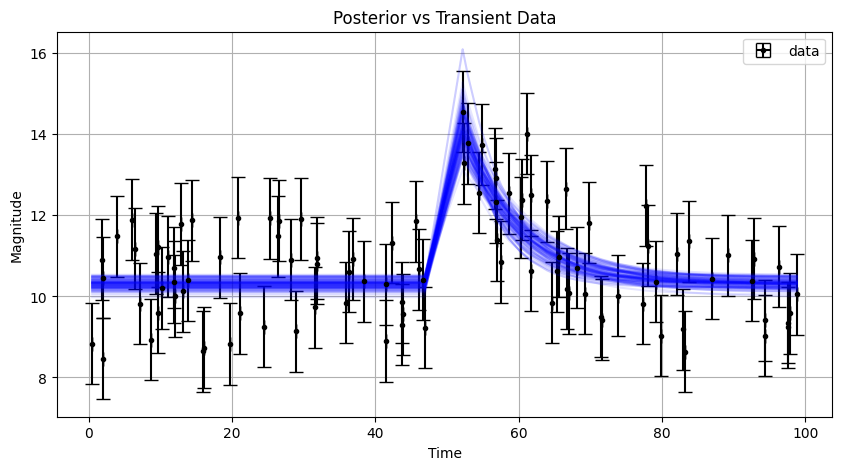

In [335]:
plt.figure(figsize=(10, 5))
plt.errorbar(Time, vals, xerr=0, yerr=errs,capsize=5, fmt=".", label="data", color='black')
for k in range(100):
    plt.plot(Time,func(Time,*np.array([p0[k],p1[k],p2[k],p3[k]])), color='blue', alpha=0.1)
plt.grid()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Posterior vs Transient Data')
plt.legend()